In [1]:
def find_max_quintile (precip, n):
    # Difference with this to Huff curve function, is it doesnt normalise
    cumulative_rainfall, cumulative_rainfall_times = create_cumulative_event(precip)
    dimensionless_cumulative_rainfall, dimensionless_times =  create_dimensionless_event(cumulative_rainfall, cumulative_rainfall_times)
    interpolated_n_cumulative_rainfall, interpolated_n_times = interpolate_rainfall(dimensionless_cumulative_rainfall,n)
    interpolated_n_incremental_rainfall = create_incremental_event(interpolated_n_cumulative_rainfall)
    max_quintile_profile = find_part_with_most_rain(interpolated_n_incremental_rainfall, n)
    
    return max_quintile_profile 


def create_cumulative_event(rainfall, interval=0.5):
    
    # Calculate cumulative rainfall
    cumulative_rainfall = np.cumsum(rainfall)
    cumulative_rainfall = [0] + cumulative_rainfall
    
    # Generate corresponding time points
    time_points = np.arange(0, len(rainfall) + 1) * interval
    
    return  [0] + cumulative_rainfall.tolist(), time_points.tolist()


def create_dimensionless_event(cumulative_rainfall, cumulative_rainfall_times):
    # Normalize the cumulative rainfall by the total event depth
    total_event_depth = cumulative_rainfall[-1]
    normalized_cumulative_rainfall = np.array(cumulative_rainfall) / total_event_depth

    # Normalize the cumulative rainfall times by the total event time
    total_event_time = cumulative_rainfall_times[-1]
    normalized_cumulative_rainfall_times = np.array(cumulative_rainfall_times) / total_event_time
    
    return normalized_cumulative_rainfall, normalized_cumulative_rainfall_times

def interpolate_rainfall(rainfall, bin_number):
    if rainfall is None or len(rainfall) < 2:
        return None

    # Define target points for bin_number bins
    target_points = np.linspace(0, 1, bin_number+1)
    
    # Create interpolation function based on existing data points
    rainfall_times = np.array(range(0, len(rainfall)))

    # Normalize time from 0 to 1
    normalized_time = (rainfall_times - rainfall_times[0]) / (rainfall_times[-1] - rainfall_times[0])
    interpolation_func = interp1d(normalized_time, rainfall, kind='linear', fill_value="extrapolate")
    
    # Interpolate values at target points
    interpolated_values = interpolation_func(target_points)
    
    return interpolated_values, target_points

def create_incremental_event(cumulative_rainfall):
    if cumulative_rainfall is None :
        return None
    raw_rainfall = np.diff(cumulative_rainfall, prepend=0)
    return raw_rainfall [1:]

def find_part_with_most_rain(array, n, plot=False, ax=False):

    # Compute differences
    # Split the array into 5 equal parts
    splits = np.array_split(array, n)

    max_array_rainfall = 0
    max_array_num = None

    total_precipitations = []  # To store total precipitation for each split
    split_ranges = []  # To store start and end indices for each split

    # Calculate total precipitation for each split
    split_start = 0
    for split in splits:
        total_precipitation = split.sum()
        total_precipitations.append(total_precipitation)
        split_end = split_start + len(split)
        split_ranges.append((split_start, split_end))
        if total_precipitation > max_array_rainfall:
            max_array_num = len(total_precipitations)
            max_array_rainfall = total_precipitation
        split_start = split_end

    colors = ['lightblue'] * n  # Default color for all splits
    highlight_color = 'yellow'  # Color for the split with the most rainfall

    if plot:
        # Plot the array
        ax.plot(range(1, len(array) + 1), array, label='Precipitation', marker='o')

        # Add vertical lines and shading for each split segment
        for i, (start_index, end_index) in enumerate(split_ranges):
            color = highlight_color if (i + 1) == max_array_num else colors[i]

            # Add vertical lines at the start and end of each split
            ax.axvline(x=start_index + 1, color=color, linestyle='--', label=f'Split {i+1} Start' if i == 0 or (i + 1) == max_array_num else "")
            ax.axvline(x=end_index, color=color, linestyle='--', label=f'Split {i+1} End' if i == 0 or (i + 1) == max_array_num else "")

            # Shade the region for the split
            ax.fill_between(range(start_index + 1, end_index + 1), array[start_index:end_index], color=color, alpha=0.3)

            # Add the total precipitation value behind the shading
            ax.text((start_index + end_index) / 2+0.5, max(array) * 0.05,  # Adjust y-position if needed
                    f'{total_precipitations[i]:.2f}',
                    ha='center', va='center', fontsize=10, color='black', weight='bold', zorder=1)

        ax.set_title(f'Precipitation Values with Splits Marked. Max at {max_array_num}')
        ax.set_xlabel('Time')
        ax.set_ylabel('Precipitation')

    return max_array_num   

# 5. Incremental Values with Highlighted Segments and Annotations
def plot_incremental_with_segments(ax, rainfall_array, n_segments=5):
    """Plot incremental values with vertical lines marking segments and annotations for total rainfall."""
    # Ensure rainfall_array is a NumPy array
    rainfall_array = np.asarray(rainfall_array)

    # Time steps for x-axis starting from 0
    time_steps = np.arange(0, len(rainfall_array))

    # Plot the incremental values
    ax.plot(time_steps, rainfall_array, label='Incremental Rainfall', marker='o', color='royalblue', 
           markerfacecolor='purple')

    # Split the array into n_segments
    segment_length = len(rainfall_array) // n_segments
    highlighted_segment_index = None
    max_rainfall = -np.inf

    # Calculate total rainfall for each segment and find the one with the maximum
    total_precipitations = []
    for i in range(n_segments):
        start_index = i * segment_length
        end_index = (i + 1) * segment_length if i < n_segments - 1 else len(rainfall_array)

        total_precipitation = rainfall_array[start_index:end_index].sum()
        total_precipitations.append(total_precipitation)

        if total_precipitation > max_rainfall:
            max_rainfall = total_precipitation
            highlighted_segment_index = i

    # Highlight the segment with the most rainfall
    for i in range(n_segments):
        if i == highlighted_segment_index:
            start_index = i * segment_length
            end_index = (i + 1) * segment_length if i < n_segments - 1 else len(rainfall_array)

            # Highlight the selected segment
            color = 'lightyellow'
            ax.fill_between(time_steps[start_index:end_index], 0, rainfall_array[start_index:end_index],
                            color=color, alpha=1)

            # Vertical line at the start of the highlighted segment
            ax.axvline(x=start_index, color='gray', linestyle='--')
            # Vertical line at the end of the highlighted segment
            ax.axvline(x=end_index - 1, color='gray', linestyle='--')

    # Set title and labels
    ax.set_title('Incremental Rainfall with Highlighted Segment')
    ax.set_xlabel('Time Step')
    ax.set_ylabel('Resampled incremental Rainfall')
    ax.grid(True)


In [5]:
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.interpolate import interp1d
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt

## Get some sample data

In [6]:
home_dir = '/nfs/a319/gy17m2a/PhD/'
home_dir2 = '/nfs/a161/gy17m2a/PhD/'

In [7]:
time_period='Future'
gauge_num=1
em = 'bb189'
indy_events_fp = home_dir2 + f"ProcessedData/IndependentEvents/UKCP18_30mins/{time_period}/{em}/{gauge_num}/WholeYear/EventSet/"

files = [f for f in os.listdir(indy_events_fp) if f.endswith('.csv')]
files = np.sort(files)
sample_short = pd.read_csv(indy_events_fp + files[20])
sample_long = pd.read_csv(indy_events_fp + files[70])

In [8]:
def find_and_plot(sample, ax, percentile):
    # ECDF (Empirical Cumulative Distribution Function) computes the cumulative probability for each point in the sample.
    # The ECDF for a given value in the sample tells us what percentage of the sample is less than or equal to that value.
    sample_edf = ECDF(sample)

    # Takes the unique values from the sample and sorts them.
    # These are the points where the ECDF will have "jumps" because the ECDF is a step function.
    slope_changes = sorted(set(sample))

    # For each unique value (slope change), we compute the ECDF value.
    # These ECDF values represent the cumulative probability at each unique point in the sample.
    sample_edf_values_at_slope_changes = [sample_edf(item) for item in slope_changes]

    # Invert the ECDF using linear interpolation.
    # This interpolation creates a smooth function that lets us input a cumulative probability and get the corresponding sample value.
    # This "flips" the ECDF so we can find what data value corresponds to any cumulative probability.
    inverted_edf = interp1d(sample_edf_values_at_slope_changes, slope_changes)

    # Create a range of cumulative probabilities (percentiles) from 10% to 100% to plot against the sample values.
    # The inverted ECDF will map these probabilities back to sample values.
    x = np.linspace(0.1, 1, 12)
    y = inverted_edf(x)

    # Plot the inverted ECDF.
    # This line represents how the cumulative probability maps back to sample values (smoothed through interpolation).
    ax.plot(x, y, 'ro', x, y, 'b-')

    # Set axis labels to clarify that we're plotting cumulative probability (percentiles) on the x-axis
    # and the corresponding sample values on the y-axis.
    ax.set_xlabel("Cumulative Probability")
    ax.set_ylabel("Sample Value")
    ax.set_title("Inverted ECDF, with ")
    # Print the value that corresponds to the 97.5th percentile in the inverted ECDF.
    # This gives us the data value at the 97.5% cumulative probability.    
    ax.grid(True)

    # Calculate the x and y coordinates for the percentile line
    percentile_x = percentile / 100
    percentile_y = inverted_edf(percentile_x)

    # Plot vertical line for the percentile
    ax.axvline(x=percentile_x, color='red', linestyle='--', label=f'{percentile}th Percentile')

    # Plot horizontal line for the corresponding sample value
    ax.axhline(y=percentile_y, color='blue', linestyle='--', label=f'Value: {percentile_y:.2f}')

    # Add legend
    ax.legend()

    # Print the value that corresponds to the specified percentile
    print(f'{percentile} percentile:', percentile_y)

    # Optionally, uncomment to plot original data points
    # ax.scatter(sample_edf.x, sample_edf.y, alpha=0.5, color='gray', label='Data Points')

def plot_ecdf(sample, ax):
    # Compute the ECDF for the sample
    sample_edf = ECDF(sample)
    
    # Sort the sample values to plot them in order
    sorted_sample = sorted(set(sample))
    
    # Plot the ECDF as a step function
    ax.step(sample_edf(sorted_sample), sorted_sample, where='post', color='blue', label='ECDF')

    # Add labels and title
    ax.set_xlabel('Cumulative Probability')  # x-axis shows the data points (sample values)
    ax.set_ylabel('Sample Value')  # y-axis shows the cumulative probability (ECDF)
    ax.set_title('Empirical CDF (ECDF) of the Sample')
    ax.grid(True)
    # Show legend and plot
    ax.legend()


In [9]:
n = 5
sample = sample_long['precipitation (mm)']
cumulative_rainfall, cumulative_rainfall_times = create_cumulative_event(sample)
dimensionless_cumulative_rainfall, dimensionless_times =  create_dimensionless_event(cumulative_rainfall, cumulative_rainfall_times)
interpolated_n_cumulative_rainfall, interpolated_n_times = interpolate_rainfall(dimensionless_cumulative_rainfall,n)
interpolated_n_incremental_rainfall = create_incremental_event(interpolated_n_cumulative_rainfall)
max_quintile_profile = find_part_with_most_rain(interpolated_n_incremental_rainfall, n)

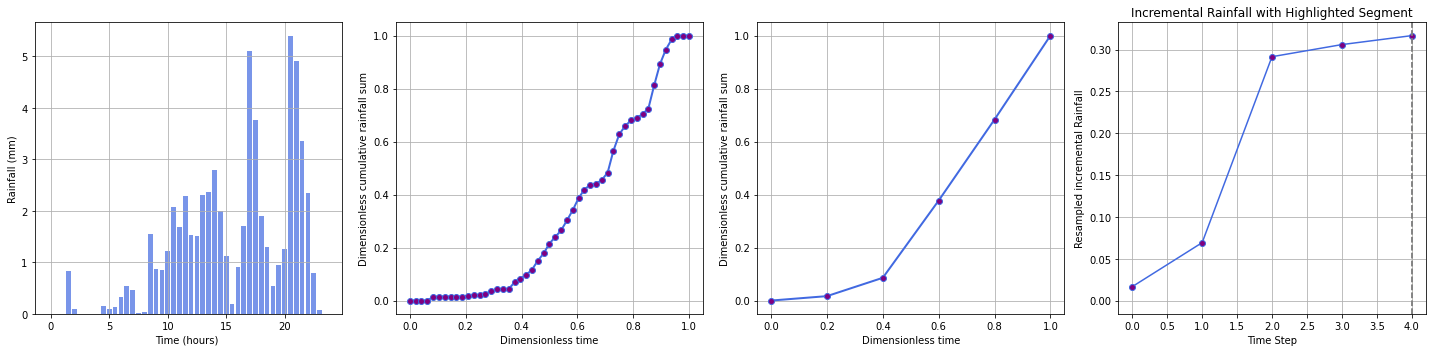

In [11]:
# Create a figure with 5 subplots
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

# 1. Raw Data Plot
# axs[0].bar(range(len(sample), sample))
axs[0].bar(np.array(range(len(sample))) * 0.5, sample, color='royalblue', alpha=0.7, width=0.4)
axs[0].set_xlabel('Time (hours) ')
axs[0].set_ylabel('Rainfall (mm)')
axs[0].grid(True)

# 2. Dimensionless Cumulative Values
axs[1].plot(dimensionless_times, dimensionless_cumulative_rainfall, label='Cumulative Sum', linewidth=2, marker='o',
            color='royalblue', markerfacecolor='purple')
# axs[1].set_title('Dimensionless Cumulative')
axs[1].set_xlabel('Dimensionless time')
axs[1].set_ylabel('Dimensionless cumulative rainfall sum')
# axs[1].legend()
axs[1].grid(True)
# # Add step plot for the raw cumulative rainfall
# axs[1].step(dimensionless_times, dimensionless_cumulative_rainfall, 
#             label='Raw Data (Cumulative)', where='post', color='orange', linestyle='-')


# 3. Interpolated Cumulative Values
axs[2].plot(interpolated_n_times, interpolated_n_cumulative_rainfall, label='Cumulative Sum',linewidth=2,  marker='o', 
            color='royalblue', markerfacecolor='purple')
# axs[2].set_title('Interpolated Cumulative')
axs[2].set_xlabel('Dimensionless time')
axs[2].set_ylabel('Dimensionless cumulative rainfall sum')
# axs[2].legend()
axs[2].grid(True)

# Call the function for the last subplot
plot_incremental_with_segments(axs[3], interpolated_n_incremental_rainfall, n_segments=5)

# Show the final figure
plt.tight_layout()
plt.show()

In [ ]:

# Define custom labels for the bars
bar_labels = ['F2', 'F1', 'C', 'B1', 'B2']

# Define the color mapping
color_mapping = {
    'F2': (0.0, 0.0, 1.0, 0.6),       # Blue with 0.6 transparency
    'F1': (0.0, 0.6902, 1.0, 0.6),    # Light blue with 0.6 transparency
    'C': (0.5, 0.5, 0.5, 0.6),        # Gray with 0.6 transparency
    'B1': (0.8039, 0.0, 0.0, 0.6),    # Red with 0.6 transparency
    'B2': (0.5451, 0.0, 0.0, 0.6)     # Dark red with 0.6 transparency
}

# Get the colors for each bar based on the label

colors = [color_mapping[label] for label in bar_labels]

# Create the bar chart
plt.bar(time_steps, rainfall_array, label='Incremental Rainfall', color=colors, edgecolor='black')

# Set custom labels on the x-axis
plt.xticks(time_steps, bar_labels)  # Assign custom labels to the x-axis

# Add a legend and display the plot
plt.show()


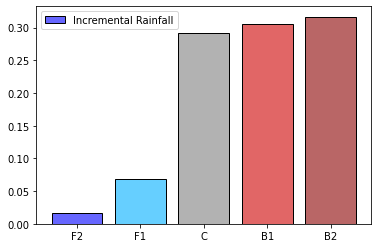

In [29]:
time_steps = np.arange(0, len(rainfall_array))

# Define custom labels for the bars
bar_labels = ['F2', 'F1', 'C', 'B1', 'B2']

# Find the index of the bar with the maximum value
index_of_max = np.argmax(rainfall_array)

# Define the colors for each bar
colors = ['white'] * len(rainfall_array)  # Default color for all bars
colors[index_of_max] = 'yellow'  # Highlight the bar with the maximum value

# Create the bar chart
plt.bar(time_steps, rainfall_array,color=colors, edgecolor='black')

# Set custom labels on the x-axis
plt.xticks(time_steps, bar_labels)  # Assign custom labels to the x-axis

# Add a legend and display the plot
plt.show()


50 percentile: 0.8764575000000001


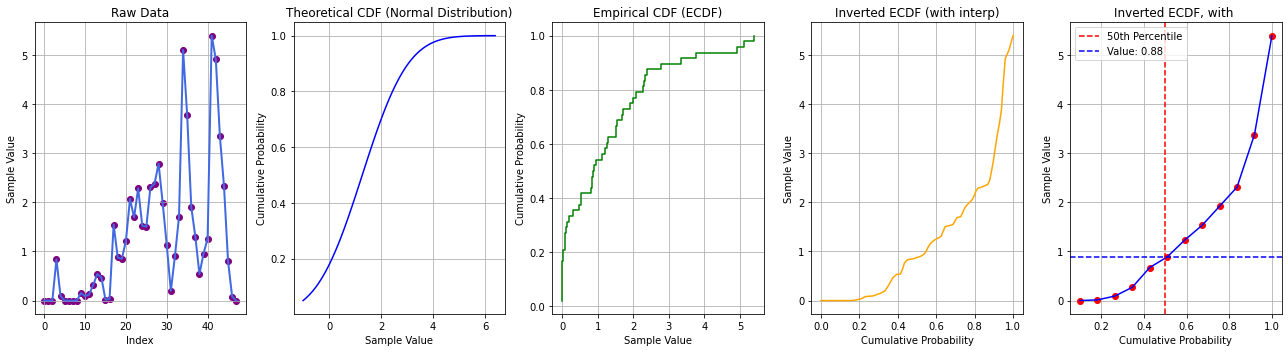

In [385]:
# Compute ECDF
sample_edf = ECDF(sample)
sorted_sample = np.sort(sample)

# Calculate CDF (Assuming normal distribution for demonstration)
mu, std = np.mean(sample), np.std(sample)
x = np.linspace(min(sample) - 1, max(sample) + 1, 100)
cdf_values = norm.cdf(x, mu, std)

# Values from the ECDF at the sorted sample values
sample_edf_values_at_sorted = sample_edf(sorted_sample)

# Invert ECDF
inverted_edf = interp1d(sample_edf_values_at_sorted, sorted_sample, bounds_error=False, fill_value=(sorted_sample[0], sorted_sample[-1]))

# Generate x values for the inverted ECDF
x_inv = np.linspace(0, 1, 100)
y_inv = inverted_edf(x_inv)

# Create the figure with 3 subplots
fig, axs = plt.subplots(1, 5, figsize=(18, 5))

# 1. Raw Data Plot
axs[0].plot(sample, label='Incremental', color='royalblue',linewidth=2)
axs[0].scatter(range(len(sample)), sample, color='purple', label='Raw Data')
axs[0].set_title('Raw Data')
axs[0].set_xlabel('Index')
axs[0].set_ylabel('Sample Value')
axs[0].grid(True)

# 1. CDF Plot
axs[1].plot(x, cdf_values, label='Normal CDF', color='blue')
axs[1].set_title('Theoretical CDF (Normal Distribution)')
axs[1].set_xlabel('Sample Value')
axs[1].set_ylabel('Cumulative Probability')
axs[1].grid(True)

# 2. ECDF Plot
axs[2].step(sorted_sample, sample_edf(sorted_sample), where='post', label='ECDF', color='green')
axs[2].set_title('Empirical CDF (ECDF)')
axs[2].set_xlabel('Sample Value')
axs[2].set_ylabel('Cumulative Probability')
axs[2].grid(True)

# 3. Inverted ECDF Plot
axs[3].plot(x_inv, y_inv, label='Inverted ECDF', color='orange')
axs[3].set_title('Inverted ECDF (with interp)')
axs[3].set_xlabel('Cumulative Probability')
axs[3].set_ylabel('Sample Value')
axs[3].grid(True)

find_and_plot(sample, axs[4], 50)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [387]:
sample = sample_long['precipitation (mm)']
n = len(sample)
cumulative_rainfall, cumulative_rainfall_times = create_cumulative_event(sample)
dimensionless_cumulative_rainfall, dimensionless_times =  create_dimensionless_event(cumulative_rainfall, cumulative_rainfall_times)
interpolated_n_cumulative_rainfall, interpolated_n_times = interpolate_rainfall(dimensionless_cumulative_rainfall,n)
interpolated_n_incremental_rainfall = create_incremental_event(interpolated_n_cumulative_rainfall)
max_quintile_profile = find_part_with_most_rain(interpolated_n_incremental_rainfall, n)

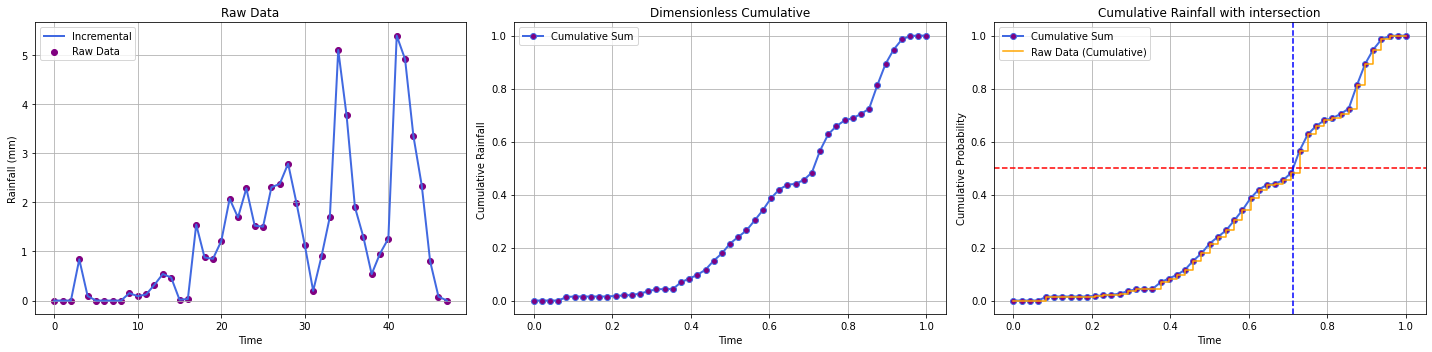

In [390]:
# Create a figure with 4 subplots
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

# 1. Raw Data Plot
axs[0].plot(sample, label='Incremental', color='royalblue', linewidth=2)
axs[0].scatter(range(len(sample)), sample, color='purple', label='Raw Data')
axs[0].set_title('Raw Data')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Rainfall (mm)')
axs[0].legend()
axs[0].grid(True)

# 2. Dimensionless Cumulative Values
axs[1].plot(dimensionless_times, dimensionless_cumulative_rainfall, label='Cumulative Sum', linewidth=2, marker='o',
            color='royalblue', markerfacecolor='purple')
axs[1].set_title('Dimensionless Cumulative')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Cumulative Rainfall ')
axs[1].legend()
axs[1].grid(True)

# 3. Interpolated Cumulative Values
# 3. Interpolated Cumulative Values
axs[2].plot(interpolated_n_times, interpolated_n_cumulative_rainfall, 
            label='Cumulative Sum', linewidth=2, marker='o', color='royalblue', markerfacecolor='purple')

# Add step plot for the raw cumulative rainfall
axs[2].step(interpolated_n_times, dimensionless_cumulative_rainfall, 
            label='Raw Data (Cumulative)', where='post', color='orange', linestyle='-')

axs[2].set_title('Cumulative Rainfall with intersection')
axs[2].set_xlabel('Time')
axs[2].set_ylabel('Cumulative Probability')
axs[2].legend()
axs[2].grid(True)

# Plot horizontal line for the corresponding sample value
axs[2].axhline(y=percentile, color='red', linestyle='--', label=f'{percentile}th Percentile')

# Plot horizontal line for the corresponding sample value at the 0.5 percentile
# axs[2].axhline(y=percentile_value, color='red', linestyle='--', label=f'{percentile*100:.1f}th Percentile')

# Find the indices where the cumulative rainfall crosses the percentile_value
indices_below = np.where(interpolated_n_cumulative_rainfall < percentile)[0]
indices_above = np.where(interpolated_n_cumulative_rainfall >= percentile)[0]

# Ensure there are indices both below and above the percentile value
if len(indices_below) > 0 and len(indices_above) > 0:
    index_below = indices_below[-1]  # Last index below the percentile value
    index_above = indices_above[0]    # First index above the percentile value
    
    # Perform linear interpolation to find the exact intersection point
    x_below = interpolated_n_times[index_below]
    y_below = interpolated_n_cumulative_rainfall[index_below]
    
    x_above = interpolated_n_times[index_above]
    y_above = interpolated_n_cumulative_rainfall[index_above]

    # Calculate the slope
    slope = (y_above - y_below) / (x_above - x_below)
    # Use the formula to find the exact x value where the y value equals percentile_value
    time_for_percentile = x_below + (percentile - y_below) / slope
    
    # Plot vertical line at the intersection
    axs[2].axvline(x=time_for_percentile, color='blue', linestyle='--')

#     # Add annotation for the intersection point
#     axs[2].annotate(f'({time_for_percentile:.2f}, {percentile:.2f})', 
#                      xy=(time_for_percentile, percentile), 
#                      xytext=(time_for_percentile + 0.05, percentile + 0.05), 
#                      arrowprops=dict(facecolor='black', arrowstyle='->'))


# Show the final figure
plt.tight_layout()
plt.show()


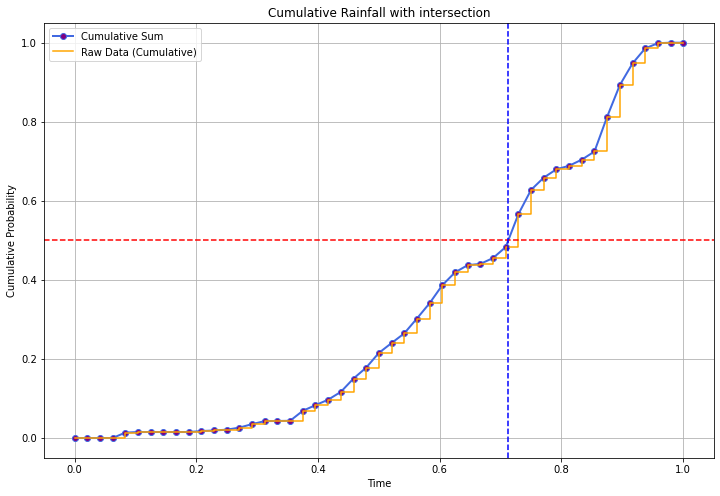

In [394]:
fig, ax=plt.subplots(figsize=(12,8))

# 3. Interpolated Cumulative Values
# 3. Interpolated Cumulative Values
ax.plot(interpolated_n_times, interpolated_n_cumulative_rainfall, 
            label='Cumulative Sum', linewidth=2, marker='o', color='royalblue', markerfacecolor='purple')

# Add step plot for the raw cumulative rainfall
ax.step(interpolated_n_times, dimensionless_cumulative_rainfall, 
            label='Raw Data (Cumulative)', where='post', color='orange', linestyle='-')

ax.set_title('Cumulative Rainfall with intersection')
ax.set_xlabel('Time')
ax.set_ylabel('Cumulative Probability')
ax.legend()
ax.grid(True)

# Plot horizontal line for the corresponding sample value
ax.axhline(y=percentile, color='red', linestyle='--', label=f'{percentile}th Percentile')

# Plot horizontal line for the corresponding sample value at the 0.5 percentile
# axs[2].axhline(y=percentile_value, color='red', linestyle='--', label=f'{percentile*100:.1f}th Percentile')

# Find the indices where the cumulative rainfall crosses the percentile_value
indices_below = np.where(interpolated_n_cumulative_rainfall < percentile)[0]
indices_above = np.where(interpolated_n_cumulative_rainfall >= percentile)[0]

# Ensure there are indices both below and above the percentile value
if len(indices_below) > 0 and len(indices_above) > 0:
    index_below = indices_below[-1]  # Last index below the percentile value
    index_above = indices_above[0]    # First index above the percentile value
    
    # Perform linear interpolation to find the exact intersection point
    x_below = interpolated_n_times[index_below]
    y_below = interpolated_n_cumulative_rainfall[index_below]
    
    x_above = interpolated_n_times[index_above]
    y_above = interpolated_n_cumulative_rainfall[index_above]

    # Calculate the slope
    slope = (y_above - y_below) / (x_above - x_below)
    # Use the formula to find the exact x value where the y value equals percentile_value
    time_for_percentile = x_below + (percentile - y_below) / slope
    
    # Plot vertical line at the intersection
    ax.axvline(x=time_for_percentile, color='blue', linestyle='--')

In [395]:
sample = sample_short['precipitation (mm)']
n = len(sample)
cumulative_rainfall, cumulative_rainfall_times = create_cumulative_event(sample)
dimensionless_cumulative_rainfall, dimensionless_times =  create_dimensionless_event(cumulative_rainfall, cumulative_rainfall_times)
interpolated_n_cumulative_rainfall, interpolated_n_times = interpolate_rainfall(dimensionless_cumulative_rainfall,n)
interpolated_n_incremental_rainfall = create_incremental_event(interpolated_n_cumulative_rainfall)
max_quintile_profile = find_part_with_most_rain(interpolated_n_incremental_rainfall, n)

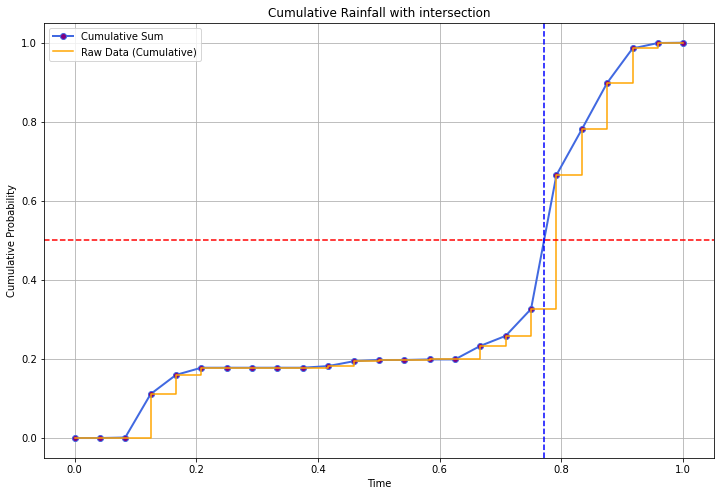

In [396]:
fig, ax=plt.subplots(figsize=(12,8))

# 3. Interpolated Cumulative Values
# 3. Interpolated Cumulative Values
ax.plot(interpolated_n_times, interpolated_n_cumulative_rainfall, 
            label='Cumulative Sum', linewidth=2, marker='o', color='royalblue', markerfacecolor='purple')

# Add step plot for the raw cumulative rainfall
ax.step(interpolated_n_times, dimensionless_cumulative_rainfall, 
            label='Raw Data (Cumulative)', where='post', color='orange', linestyle='-')

ax.set_title('Cumulative Rainfall with intersection')
ax.set_xlabel('Time')
ax.set_ylabel('Cumulative Probability')
ax.legend()
ax.grid(True)

# Plot horizontal line for the corresponding sample value
ax.axhline(y=percentile, color='red', linestyle='--', label=f'{percentile}th Percentile')

# Plot horizontal line for the corresponding sample value at the 0.5 percentile
# axs[2].axhline(y=percentile_value, color='red', linestyle='--', label=f'{percentile*100:.1f}th Percentile')

# Find the indices where the cumulative rainfall crosses the percentile_value
indices_below = np.where(interpolated_n_cumulative_rainfall < percentile)[0]
indices_above = np.where(interpolated_n_cumulative_rainfall >= percentile)[0]

# Ensure there are indices both below and above the percentile value
if len(indices_below) > 0 and len(indices_above) > 0:
    index_below = indices_below[-1]  # Last index below the percentile value
    index_above = indices_above[0]    # First index above the percentile value
    
    # Perform linear interpolation to find the exact intersection point
    x_below = interpolated_n_times[index_below]
    y_below = interpolated_n_cumulative_rainfall[index_below]
    
    x_above = interpolated_n_times[index_above]
    y_above = interpolated_n_cumulative_rainfall[index_above]

    # Calculate the slope
    slope = (y_above - y_below) / (x_above - x_below)
    # Use the formula to find the exact x value where the y value equals percentile_value
    time_for_percentile = x_below + (percentile - y_below) / slope
    
    # Plot vertical line at the intersection
    ax.axvline(x=time_for_percentile, color='blue', linestyle='--')

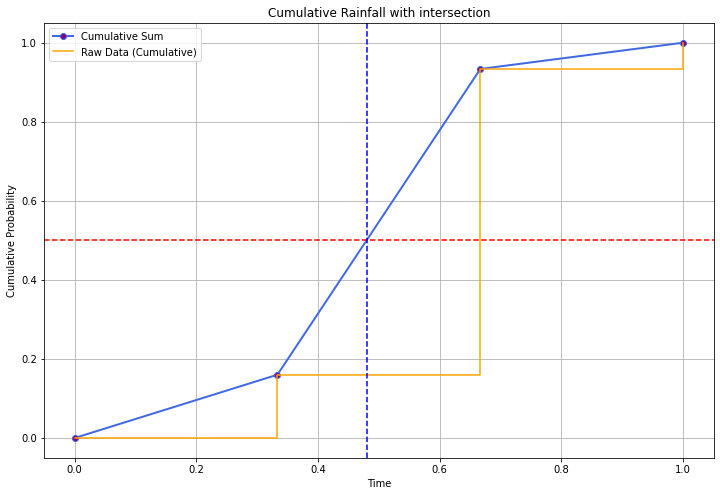

In [399]:
sample_short = pd.read_csv(indy_events_fp + files[1])
sample = sample_short['precipitation (mm)']
n = len(sample)
cumulative_rainfall, cumulative_rainfall_times = create_cumulative_event(sample)
dimensionless_cumulative_rainfall, dimensionless_times =  create_dimensionless_event(cumulative_rainfall, cumulative_rainfall_times)
interpolated_n_cumulative_rainfall, interpolated_n_times = interpolate_rainfall(dimensionless_cumulative_rainfall,n)
interpolated_n_incremental_rainfall = create_incremental_event(interpolated_n_cumulative_rainfall)
max_quintile_profile = find_part_with_most_rain(interpolated_n_incremental_rainfall, n)

fig, ax=plt.subplots(figsize=(12,8))

# 3. Interpolated Cumulative Values
# 3. Interpolated Cumulative Values
ax.plot(interpolated_n_times, interpolated_n_cumulative_rainfall, 
            label='Cumulative Sum', linewidth=2, marker='o', color='royalblue', markerfacecolor='purple')

# Add step plot for the raw cumulative rainfall
ax.step(interpolated_n_times, dimensionless_cumulative_rainfall, 
            label='Raw Data (Cumulative)', where='post', color='orange', linestyle='-')

ax.set_title('Cumulative Rainfall with intersection')
ax.set_xlabel('Time')
ax.set_ylabel('Cumulative Probability')
ax.legend()
ax.grid(True)

# Plot horizontal line for the corresponding sample value
ax.axhline(y=percentile, color='red', linestyle='--', label=f'{percentile}th Percentile')

# Plot horizontal line for the corresponding sample value at the 0.5 percentile
# axs[2].axhline(y=percentile_value, color='red', linestyle='--', label=f'{percentile*100:.1f}th Percentile')

# Find the indices where the cumulative rainfall crosses the percentile_value
indices_below = np.where(interpolated_n_cumulative_rainfall < percentile)[0]
indices_above = np.where(interpolated_n_cumulative_rainfall >= percentile)[0]

# Ensure there are indices both below and above the percentile value
if len(indices_below) > 0 and len(indices_above) > 0:
    index_below = indices_below[-1]  # Last index below the percentile value
    index_above = indices_above[0]    # First index above the percentile value
    
    # Perform linear interpolation to find the exact intersection point
    x_below = interpolated_n_times[index_below]
    y_below = interpolated_n_cumulative_rainfall[index_below]
    
    x_above = interpolated_n_times[index_above]
    y_above = interpolated_n_cumulative_rainfall[index_above]

    # Calculate the slope
    slope = (y_above - y_below) / (x_above - x_below)
    # Use the formula to find the exact x value where the y value equals percentile_value
    time_for_percentile = x_below + (percentile - y_below) / slope
    
    # Plot vertical line at the intersection
    ax.axvline(x=time_for_percentile, color='blue', linestyle='--')